In [88]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [3]:
# Random seed
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# Load data
df = pd.read_csv('../data/BMED_data_v7.csv')

In [5]:
# Feedforward network for migration prediction
class MigrationPredictor(nn.Module):
    def __init__(self, hidden_nodes = 64, hidden_layers = 3):
        super().__init__()
        
        n_features = 7
        n_outputs = 4

        # Layer configuration
        layers = []
        # input layer
        layers.append(nn.Linear(n_features, hidden_nodes))
        layers.append(nn.ReLU())

        # hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(nn.ReLU())

        # output layer
        layers.append(nn.Linear(hidden_nodes, n_outputs))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
# Physical Layers for State update
class PhysicalLayer:
    def __init__(self, dt = 0.1):
        self.dt = dt
    
    def update_state(self, cur_states, migrations):
        # Current States
        T = cur_states[0]
        V = cur_states[1]
        E = cur_states[2]
        CF_LA = cur_states[3]
        CA_LA = cur_states[4]
        CF_K = cur_states[5]
        CB_K = cur_states[6]
        VF = cur_states[7]
        VA = cur_states[8]
        VB = cur_states[9]
        
        # Migration
        dNLA = migrations[0] * self.dt
        dNK = migrations[1] * self.dt
        dVA = migrations[2] * self.dt
        dVB = migrations[3] * self.dt

        # Fixed variables
        nT = T
        nV = V
        nE = E     
        
        # New Volumes
        nVF = VF - dVA - dVB
        nVA = VA + dVA
        nVB = VB + dVB

        # New Concentrations
        nCF_LA = (CF_LA * VF - dNLA) / nVF
        nCA_LA = (CA_LA * VA + dNLA) / nVA
        nCF_K = (CF_K * VF - dNK) / nVF
        nCB_K = (CB_K * VB + dNK) / nVB

        # New States
        new_states = cur_states.clone()
        new_states[0] = nT
        new_states[1] = nV
        new_states[2] = nE
        new_states[3] = nCF_LA
        new_states[4] = nCA_LA
        new_states[5] = nCF_K
        new_states[6] = nCB_K
        new_states[7] = nVF
        new_states[8] = nVA
        new_states[9] = nVB
        
        return new_states

In [7]:
class BMEDDataset(Dataset):
    def __init__(self, dict_spline):
        self.states = ['T', 'V', 'E', 'CF_LA', 'CA_LA', 'CF_K', 'CB_K', 'VF', 'VA', 'VB']
        self.experiments = []

        for exp_id, exp_data in dict_spline.items():
            # Save whole data of each experiment in one sample
            exp_array = exp_data[self.states].values
            times = exp_data['t'].values
            self.experiments.append({
                'init_state': torch.tensor(exp_array[0], dtype = torch.float32), # initial state
                'measured_state': torch.tensor(exp_array, dtype = torch.float32), # whole measurements
                'times': torch.tensor(times, dtype = torch.float32) # time points
            })
    
    def __len__(self):
        return len(self.experiments)
    
    def __getitem__(self, idx):
        return self.experiments[idx]

In [8]:
class BMEDModel(nn.Module):
    def __init__(self, hidden_nodes = 32, hidden_layers = 3, dt = 0.1, scaler = None):
        super().__init__()
        self.migration_predictor = MigrationPredictor(hidden_nodes, hidden_layers)
        self.physical_layer = PhysicalLayer(dt)
        self.scaler = scaler
        self.dt = dt

    def forward(self, init_state, times):

        cur_state = init_state # batch size 1
        cur_time = 0.0
        pred_states = []
        measured_indices = []

        times = times
        times_np = times[0].numpy()
        max_time = times_np[-1]
        measured_indices.append(0)

        # 초기 상태 저장
        pred_states.append(cur_state)

        while cur_time < max_time:
            # input_feature에 해당하는 변수만 정규화
            input_state = cur_state[:, :7]  # input feature 추출, 2차원 유지지
            
            norm_input = self.scaler.transform(input_state.detach().numpy())
            norm_input = torch.tensor(norm_input)
            
            # 상태 예측
            migration = self.migration_predictor(norm_input)  # (1, 6) -> (1, 3)
            cur_state = self.physical_layer.update_state(cur_state[0], migration[0]).unsqueeze(0)  # (1,8)
            pred_states.append(cur_state)  # (1, 8)
            cur_time += self.dt

            # 측정 시간과 매칭
            for t in times_np:
                if abs(cur_time - t) < self.dt/2:
                    measured_indices.append(len(pred_states) - 1)

        # 현재 배치의 예측 상태들을 스택
        pred_states = torch.cat(pred_states, dim=0)  # (n_steps, 8)

        return pred_states, measured_indices

In [9]:
def custom_loss(pred_states, measured_indices, measured_states):
    total_loss = 0
    for idx, measured_state in zip(measured_indices, measured_states[0]):
        predicted_state = pred_states[idx]
        total_loss += torch.mean((predicted_state - measured_state) ** 2)

    return total_loss

In [36]:
def train_model(model, train_loader, epochs = 100, learning_rate = 0.001, weight_decay = 1e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay)

    for epoch in range(epochs):
        model.train()

        for exp in train_loader:
            optimizer.zero_grad()

            init_state = exp['init_state']
            measured_state = exp['measured_state']
            times = exp['times']

            # Simulation
            pred_state, measured_indices = model(init_state, times)

            # Loss
            loss = custom_loss(pred_state, measured_indices, measured_state)

            loss.backward()
            optimizer.step()

In [37]:
def evaluate_model(model, val_loader):
    model.eval()
    total_r2 = 0
    total_samples = 0

    with torch.no_grad():
        for exp in val_loader:
            init_state = exp['init_state']
            measured_state = exp['measured_state']
            times = exp['times']

            for

In [ ]:
def r2_calculator(pred_states, measured_indices, measured_states):

    pred_value = pred_states[measured_indices][:,3:].numpy()
    target_value = measured_states[0][:,3:].numpy()

    r2_scores = []
    for col in range(pred_value.shape[1]):
        col_r2 = r2_score(pred_value[:,col], target_value[:,col])
        r2_scores.append(col_r2)
        print(f"Column {col+1} R2 Score: {col_r2}")
    print(f'\nAverage R2 Score: {np.mean(r2_scores)}')




In [11]:
def prepare_data(df_path, exp_idx = None):
    # Load raw data
    df = pd.read_csv(df_path)

    if exp_idx is not None:
        df = df[df['exp'].isin(exp_idx)]

    # split the data by experiment number
    dict_spline = {}
    for exp in df['exp'].unique():
        dict_spline[exp] = df[df['exp'] == exp].sort_values('t')

    # scaler
    scaler = StandardScaler()
    col_to_scale = ['T', 'V', 'E', 'CF_LA', 'CA_LA', 'CF_K', 'CB_K']
    scaler.fit(df[col_to_scale].values)
    return dict_spline, scaler

In [12]:
def plot_results(model, dataset, exp_idx=0):
    # 데이터 준비
    exp = dataset.experiments[exp_idx]
    init_state = torch.tensor(exp['init_state'], dtype=torch.float32).unsqueeze(0)
    times = torch.tensor(exp['times'], dtype=torch.float32).unsqueeze(0)
    measured_state = torch.tensor(exp['measured_state'], dtype=torch.float32)
    
    # 예측
    with torch.no_grad():
        pred_states, measured_indices = model(init_state, times)
    
    # 예측을 위한 시간 포인트 생성 (dt = 0.1 간격)
    t_pred = torch.arange(0, times[0][-1].item() + 0.1, 0.1)
    
    # 변수 이름과 단위
    var_names = {
        'T': 'Temperature (°C)',
        'V': 'Voltage (V)',
        'E': 'Electric Field (V/cm)',
        'CF_LA': 'Feed LA Conc. (M)',
        'CA_LA': 'Acid LA Conc. (M)',
        'CF_K': 'Feed K Conc. (M)',
        'CB_K': 'Base K Conc. (M)',
        'VF': 'Feed Volume (L)',
        'VA': 'Acid Volume (L)',
        'VB': 'Base Volume (L)'
    }
    
    # 그래프 그리기
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    axes = axes.ravel()
    
    for i, (var, label) in enumerate(var_names.items()):
        ax = axes[i]
        # 실제 측정값 (점으로 표시)
        ax.plot(times[0].numpy(), measured_state[:, i].numpy(), 
                'bo', label='Measured', markersize=6)
        # 예측값 (연속 선으로 표시)
        ax.plot(t_pred.numpy(), pred_states[:, i].numpy(), 
                'r-', label='Predicted', linewidth=2)
        
        ax.set_title(label, fontsize=12, pad=10)
        ax.set_xlabel('Time (hr)', fontsize=10)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [35]:
def objective(trial):
    # load data
    df_path = '../data/BMED_data_v8.csv'
    dict_spline, scaler = prepare_data(df_path)

    # Hyperparameter 설정
    hidden_nodes = trial.suggest_int('hidden_nodes', 16, 128, step = 16)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 10)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log = True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log = True)
    epochs = trial.suggest_int('epochs', 100, 1000, step = 100)
    dt = 0.1

    # 5-fold 설정
    kfolds = 5
    kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)

    # dataset 생성
    dataset = BMEDDataset(dict_spline)

    # k-fold 교차 검증 스코어 저장
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        # kfold로 전체 dataset에 대해서 train과 validation subset을 생성
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Dataloader 생성
        train_loader = DataLoader(train_subset, batch_size = 1, shuffle = True)
        val_loader = DataLoader(val_subset, batch_size = 1, shuffle = False)

        # 모델 생성
        model = BMEDModel(hidden_nodes=hidden_nodes, hidden_layers=hidden_layers, dt = dt, scaler=scaler)

        # 학습 설정
        optimizer         

    

{'init_state': tensor([20.2400, 20.0000,  0.2500,  1.0000,  0.0000,  2.0000,  0.0000,  1.0000,
         1.0000,  2.0000]), 'measured_state': tensor([[2.0240e+01, 2.0000e+01, 2.5000e-01, 1.0000e+00, 0.0000e+00, 2.0000e+00,
         0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00],
        [2.0240e+01, 2.0000e+01, 2.5000e-01, 9.4500e-01, 1.5000e-02, 1.8480e+00,
         3.7000e-02, 1.0420e+00, 9.7300e-01, 1.9850e+00],
        [2.0240e+01, 2.0000e+01, 2.5000e-01, 9.0900e-01, 3.0000e-02, 1.6800e+00,
         1.0500e-01, 1.0670e+00, 9.6800e-01, 1.9650e+00],
        [2.0240e+01, 2.0000e+01, 2.5000e-01, 8.3100e-01, 6.3000e-02, 1.2110e+00,
         3.2500e-01, 1.1330e+00, 9.3200e-01, 1.9350e+00],
        [2.0240e+01, 2.0000e+01, 2.5000e-01, 8.0000e-01, 1.0100e-01, 9.5900e-01,
         4.7200e-01, 1.1330e+00, 9.3200e-01, 1.9350e+00],
        [2.0240e+01, 2.0000e+01, 2.5000e-01, 7.3900e-01, 1.9000e-01, 6.8500e-01,
         6.3500e-01, 1.1110e+00, 9.3900e-01, 1.9490e+00],
        [2.0240e+01, 2.00

In [39]:
# Generate Dataloader
df_path = '../data/BMED_data_v8.csv'
exp_idx = [1,2]
dict_spline, scaler = prepare_data(df_path,exp_idx)

dataset = BMEDDataset(dict_spline)
train_loader = DataLoader(dataset, batch_size = 1, shuffle = True)

In [45]:
# Generate Model
hidden_nodes = 128
hidden_layers = 3
dt = 0.1
epochs = 100
lr = 0.001
wd = 1e-5
model = BMEDModel(hidden_nodes=hidden_nodes, hidden_layers=hidden_layers, dt = dt, scaler=scaler)
train_model(model=model, train_loader=train_loader, epochs = epochs, learning_rate=lr, weight_decay = wd)

In [46]:
model.eval()

BMEDModel(
  (migration_predictor): MigrationPredictor(
    (model): Sequential(
      (0): Linear(in_features=7, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
)

In [61]:
with torch.no_grad():
    for exp in train_loader:
        init_state = exp['init_state']
        times = exp['times']
        measured_states = exp['measured_state']

        pred_states, measured_indices = model(init_state, times)
        


In [ ]:
r2_sum = 0
count = 0

pred



Column 1 R2 Score: 0.9991553425788879
Column 2 R2 Score: 0.9990977048873901
Column 3 R2 Score: 0.9940641522407532
Column 4 R2 Score: 0.9869129657745361
Column 5 R2 Score: 0.8540984392166138
Column 6 R2 Score: -1.7797844409942627
Column 7 R2 Score: 0.9513657093048096

Average R2 Score: 0.5721299818583897


In [90]:
print(pred_value)
print(target_value)


[[0.5        0.         1.         0.         1.         1.
  1.        ]
 [0.4858036  0.01490184 0.9431782  0.05853523 0.99839437 1.0050045
  0.9966013 ]
 [0.46058843 0.03826597 0.8261493  0.17376582 1.0019269  1.0067452
  0.991328  ]
 [0.39956957 0.10170648 0.60305375 0.4002426  0.99531454 1.0058616
  0.998824  ]
 [0.2942177  0.2199272  0.37606108 0.615875   0.94599026 1.0079376
  1.0460728 ]
 [0.11021408 0.4066077  0.2064804  0.7275879  0.889375   0.9886147
  1.1220113 ]]
[[ 0.5    0.     1.     0.     1.     1.     1.   ]
 [ 0.482  0.007  0.993 -0.016  1.023  0.993  0.983]
 [ 0.454  0.035  0.811  0.173  1.023  0.993  0.983]
 [ 0.404  0.103  0.592  0.412  0.983  1.003  1.013]
 [ 0.298  0.214  0.376  0.625  0.943  1.024  1.034]
 [ 0.112  0.408  0.221  0.716  0.907  0.977  1.116]]


C:\Users\USER\AppData\Local\Temp\ipykernel_30508\2674379844.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_state = torch.tensor(exp['init_state'], dtype=torch.float32).unsqueeze(0)
C:\Users\USER\AppData\Local\Temp\ipykernel_30508\2674379844.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(exp['times'], dtype=torch.float32).unsqueeze(0)
C:\Users\USER\AppData\Local\Temp\ipykernel_30508\2674379844.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  measured_state = torch.tensor(exp['measured_state'], dtype=t

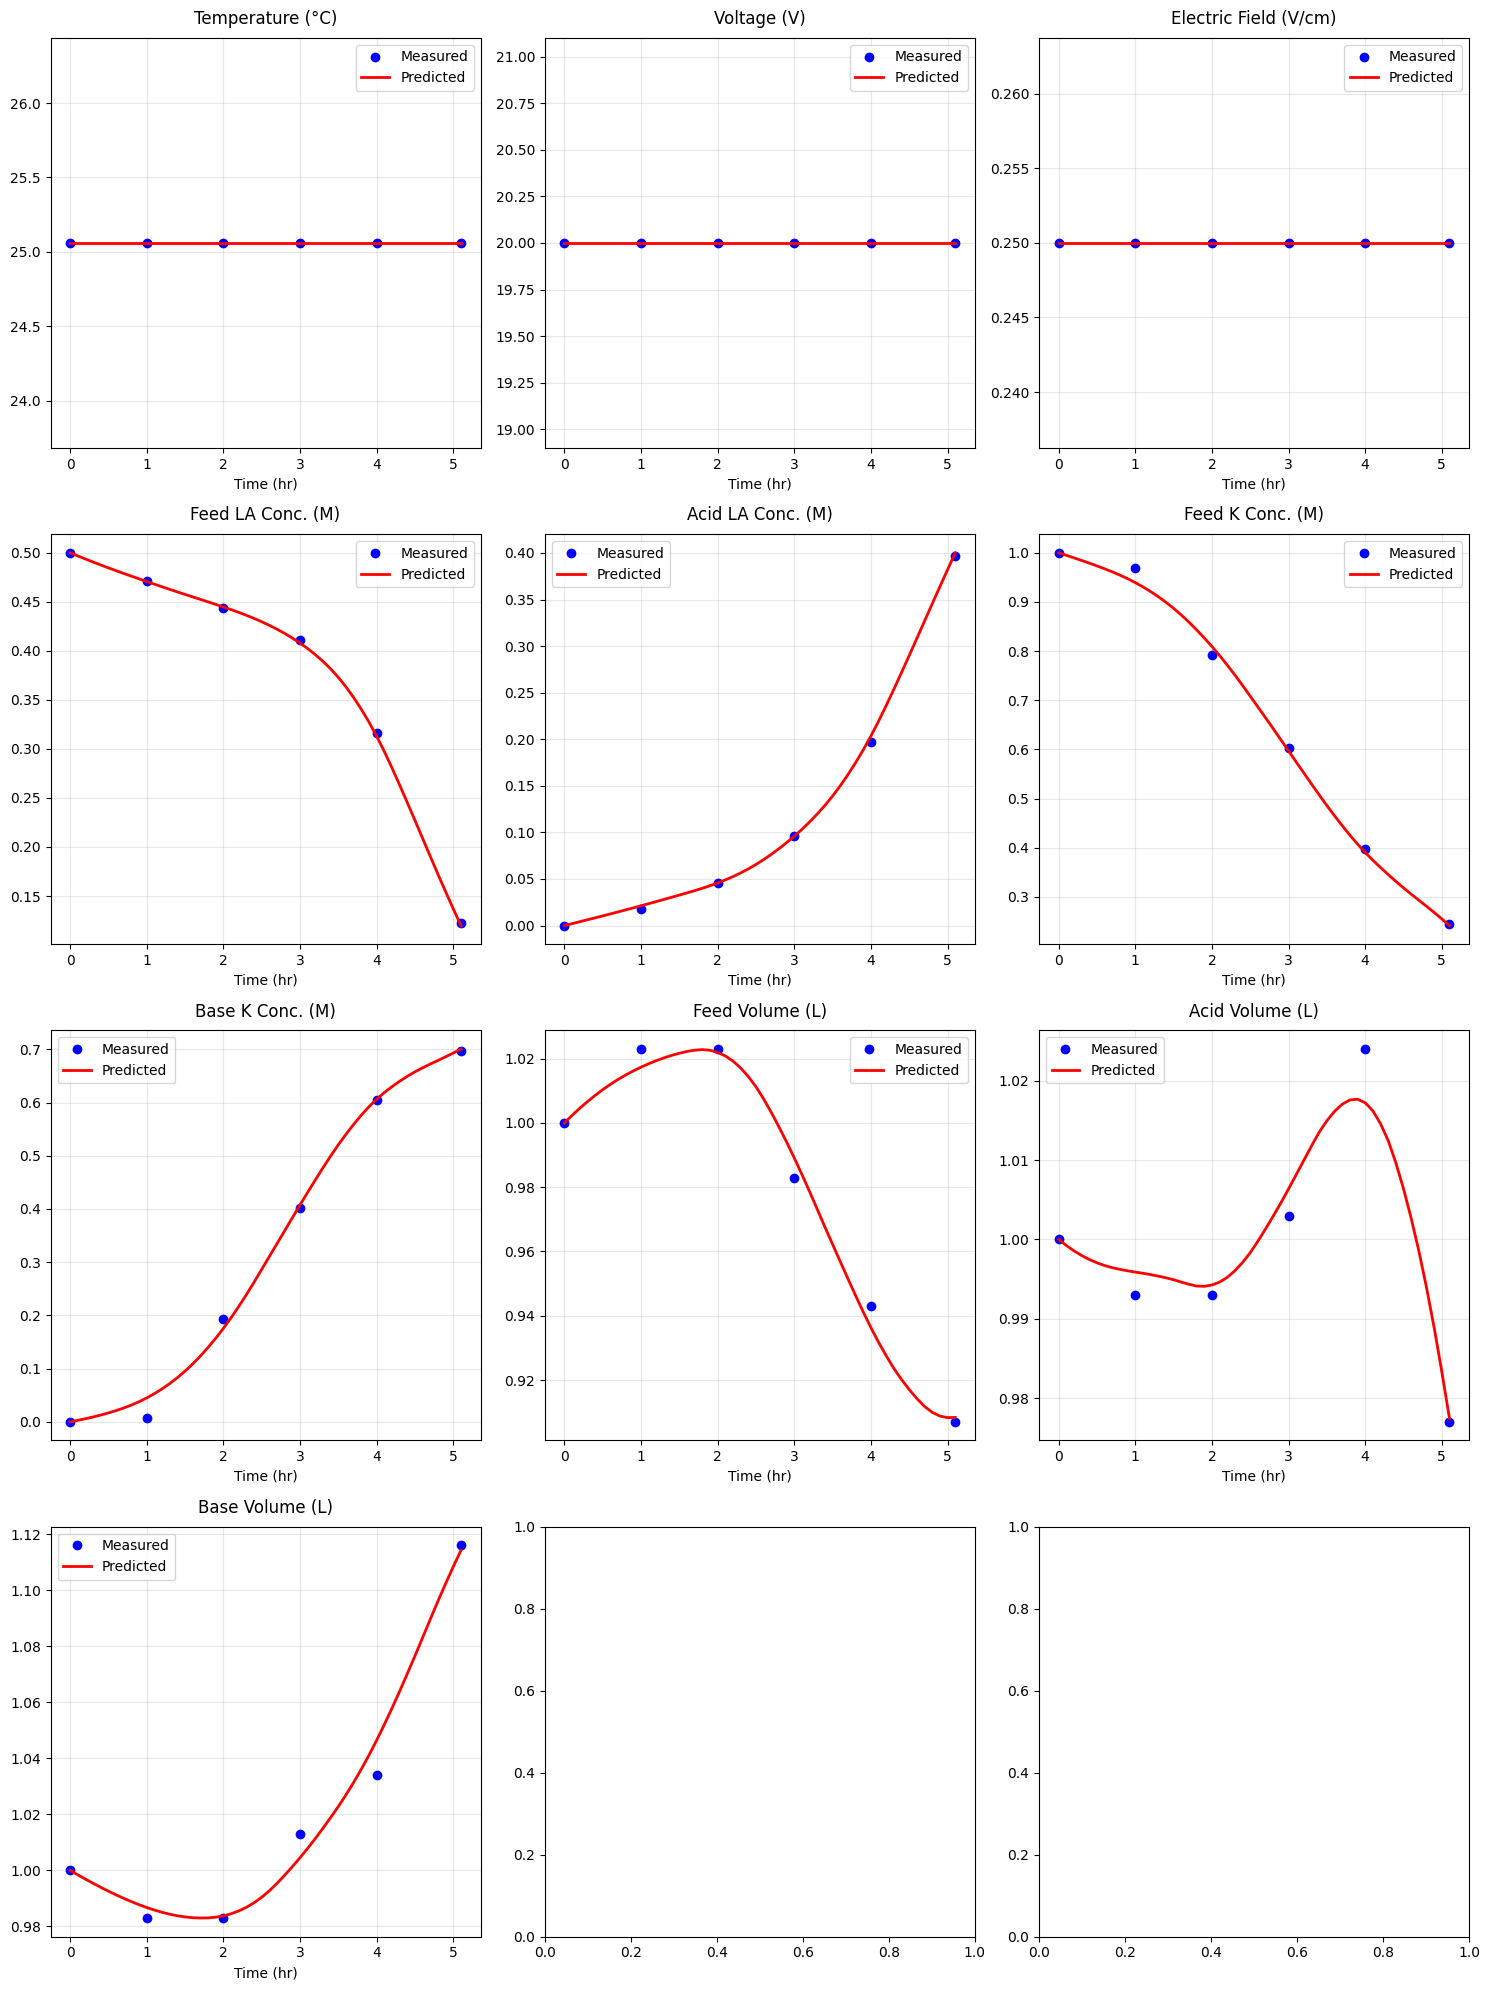

In [18]:
# 사용 예시:
plot_results(model, dataset, exp_idx=0)  # exp_idx로 실험 선택

In [ ]:
import optuna
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

def objective(trial):
    # 하이퍼파라미터 정의
    hidden_nodes = trial.suggest_int('hidden_nodes', 16, 256, log=True)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    epochs = trial.suggest_int('epochs', 100, 1000, log=True)
    
    # k-fold 교차 검증 설정
    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # 데이터셋 준비 (전체 데이터셋 가정)
    dataset = YourDataset()  # 자신의 데이터셋 클래스로 대체
    
    # k-fold 교차 검증 스코어 저장
    fold_scores = []
    
    # 각 폴드에 대해 학습 및 평가
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"Fold {fold+1}/{k_folds}")
        
        # 데이터 로더 생성
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)
        
        # 모델 초기화
        model = BMEDModel(
            input_node=6,  # 입력 차원에 맞게 조정
            hidden_nodes=hidden_nodes,
            hidden_layers=hidden_layers,
            output_nodes=3,  # 출력 차원에 맞게 조정
            dt=0.1
        )
        
        # 학습 설정
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )
        
        # 학습 루프
        for epoch in range(epochs):
            # 학습
            model.train()
            for batch in train_loader:
                optimizer.zero_grad()
                
                init_state = batch['init_state'].float()
                measured_state = batch['measured_state'].float()
                times = batch['times'].float()
                
                pred_state, measured_indices = model(init_state, times)
                loss = custom_loss(pred_state, measured_indices, measured_state)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()
            
            # 중간에 Optuna pruner를 위한 검증
            if epoch % 50 == 0 or epoch == epochs - 1:
                val_score = evaluate_model(model, val_loader)
                trial.report(val_score, epoch)
                
                # 성능 저하 시 조기 종료
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
        
        # 최종 검증 점수
        final_score = evaluate_model(model, val_loader)
        fold_scores.append(final_score)
        
        # 리소스 확보를 위한 정리
        del model, optimizer
        torch.cuda.empty_cache()
    
    # 평균 점수 반환 (R² 값이 높을수록 좋음)
    mean_score = np.mean(fold_scores)
    return mean_score

# 검증 함수
def evaluate_model(model, val_loader):
    model.eval()
    total_r2 = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in val_loader:
            init_state = batch['init_state'].float()
            measured_state = batch['measured_state'].float()
            times = batch['times'].float()
            
            pred_state, measured_indices = model(init_state, times)
            r2 = calculate_r2(pred_state, measured_indices, measured_state)
            
            batch_size = init_state.shape[0]
            total_r2 += r2 * batch_size
            total_samples += batch_size
    
    avg_r2 = total_r2 / total_samples
    return avg_r2

# R² 계산 함수
def calculate_r2(pred, indices, target):
    # 각 배치 항목에 대한 R² 계산
    r2_sum = 0
    count = 0
    
    for b in range(len(indices)):
        # 실제 값과 예측 값 추출
        pred_values = pred[b, indices[b]]
        target_values = target[b]
        
        # 각 출력 변수별 R² 계산
        for i in range(pred_values.shape[1]):
            if torch.var(target_values[:, i]) > 0:  # 분산이 0이 아닌 경우에만 계산
                r2 = 1 - torch.sum((pred_values[:, i] - target_values[:, i])**2) / \
                     torch.sum((target_values[:, i] - torch.mean(target_values[:, i]))**2)
                
                # NaN이나 무한대가 아니면 합산
                if torch.isfinite(r2):
                    r2_sum += r2
                    count += 1
    
    # 평균 R² 반환
    return r2_sum / count if count > 0 else 0.0

# Optuna 최적화 실행
study = optuna.create_study(
    direction='maximize',  # R²를 최대화
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50)
)
study.optimize(objective, n_trials=50)  # 시행 횟수 조정

# 최적 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")